In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import vice
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from vice_utils import calculate_z, sample_stars, filter_stars, show_stars, R_to_zone, zone_to_R, show_at_R_z, AGB_MODELS
from yields import y_c_agb, y_c_agb2
import yields
import scipy
from plotting_utils import fig_saver
import pandas as pd
import apogee_analysis as aah
import matplotlib as mpl
from cycler import cycler

In [4]:
sf = fig_saver("figures/")

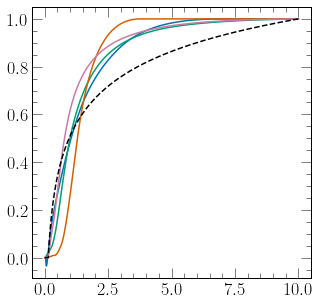

In [5]:
AGB_MODELS = ["cristallo11", "karakas10", "ventura13", "karakas16"]
AGB_LABELS = ["C11+C15", "K10", "V13", "KL16+K18"]
vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0

for i in range(4):
    model = AGB_MODELS[i]
    vice.yields.agb.settings["c"] = model
    m_c, times = vice.single_stellar_population("c", Z=0.00014)
    m_c = [c for c in m_c]
    plt.plot(times, np.array(m_c)/m_c[-1])

m_fe, times = vice.single_stellar_population("fe", Z=0.014)
m_fe = [fe for fe in m_fe]
plt.plot(times, np.array(m_fe)/m_fe[-1], label=r"Fe; $R_{Ia} \propto t^{-1.1}$", linestyle="--", color="k")

In [6]:
tau_rise = 2
tau_sfh = 15
def sfh(t):
    return (1-np.exp(-t/tau_rise)) * np.exp(-t/tau_sfh)

A = 1.5
s_burst = 1
t_burst = 11.2
def lateburst(t):
    return sfh(t) * (1 + A * np.exp(-(t-t_burst)**2/(2*s_burst**2)))

In [7]:
def convolve(agb_model, f, elem="c"):
    vice.yields.agb.settings["c"] = model
    m_c, times = vice.single_stellar_population(elem, Z=0.014, time=13.2)
    m_c = np.array([c for c in m_c])
    times = np.array(times)[:-1]
    
    dtd = (m_c[1:] - m_c[:-1])/m_c[-1]
    
    conv = []
    for t in times:
        filt = times < t
        conv.append(sum(f(times[filt][::-1]) * dtd[filt]))
    
    conv = np.array(conv)
    return conv, times

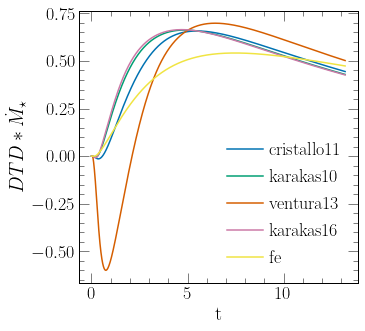

In [8]:
for model in AGB_MODELS:
    conv, times = convolve(model, sfh)
    plt.plot(times, conv, label=model)
conv, times = convolve(model, sfh, "fe")
plt.plot(times, conv, label="fe") 
    
plt.ylabel(r"$DTD \ast \dot{M}_\star$")
plt.xlabel("t")
plt.legend()

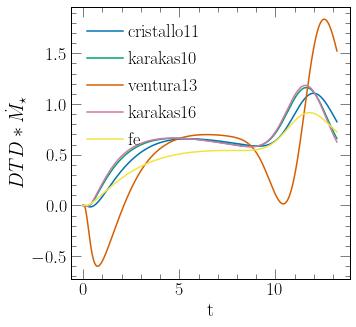

In [9]:
for model in AGB_MODELS:
    conv, times = convolve(model, lateburst)
    plt.plot(times, conv, label=model)

conv, times = convolve(model, lateburst, "fe")
plt.plot(times, conv, label="fe") 
    
plt.ylabel(r"$DTD \ast \dot{M}_\star$")
plt.xlabel("t")
plt.legend()

Text(0, 0.5, '$DTD \\ast \\dot{M}_\\star$')

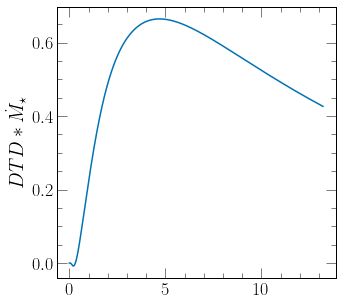

In [10]:
conv, times = convolve("cristallo11", sfh)
plt.plot(times, conv)
plt.ylabel(r"$DTD \ast \dot{M}_\star$")

In [11]:
A = 1.5
s_burst = 1
t_burst = 11.2
def run_model(eta_factor = 1, func=sfh, t_max=13.2):
    if eta_factor != 1:
        pass
    for ele in ["o", "fe"]:
        vice.yields.ccsne.settings[ele] *= eta_factor

    model = vice.singlezone(func=func, mode="sfr", dt=0.01, elements=("n", "o", "fe", "c"), eta=2.17*eta_factor)
    out = model.run(np.linspace(0, t_max, round(10*t_max + 1)), overwrite=True, capture=True)
    return out


In [12]:
def show_agb(out, ax=None, fig=None):
    if ax is None:
        fig, ax = plt.subplots()
    x = out.history["time"][:-1]
    y = calc_agb(out.history)
    plt.plot(x, y)


In [13]:
vice.yields.ccsne.settings["c"] = 0.005

In [14]:
vice.yields.ccsne.settings["fe"] = 0.0012

In [15]:
def calc_agb(h):
    def y_c_cc(z):
        return 0.005
    sfr = np.array(h["sfr"][:-1])
    z_o = np.array(h["z(o)"][1:])
    z_c = np.array(h["z(c)"][1:])
    z = 0.014*10**np.array(h["[m/h]"][:-1])
    eta = np.array(h["eta_0"][1:])
    r = np.array(h["r_eff"][1:])
    t = h["time"][:-1]

    dt = (t[1] - t[0])*10**9
    m_dot_c = (h["mass(c)"][1:] - np.array(h["mass(c)"][:-1]))/dt

    m_dot_c_out = - sfr * z_c*(1 + eta - r)
    m_dot_c_cc = sfr*y_c_cc(z)
    m_dot_c_agb = m_dot_c - m_dot_c_cc - m_dot_c_out
    m_dot_c_total = m_dot_c_cc + m_dot_c_agb
    return m_dot_c_agb

def calc_ia(h):
    dy_fe_ia = 0.015
    sfr = np.array(h["sfr"][:-1])
    z_o = np.array(h["z(o)"][1:])
    z_fe = np.array(h["z(fe)"][1:])
    z = 0.014*10**np.array(h["[m/h]"][:-1])
    eta = np.array(h["eta_0"][1:])
    r = np.array(h["r_eff"][1:])
    t = h["time"][:-1]

    dt = (t[1] - t[0])*10**9
    m_dot_fe = (h["mass(fe)"][1:] - np.array(h["mass(fe)"][:-1]))/dt

    m_dot_fe_out = - sfr * z_fe*(1 + eta - r)
    m_dot_fe_cc = sfr*vice.yields.ccsne.settings["fe"]
    m_dot_fe_ia = m_dot_fe - m_dot_fe_cc - m_dot_fe_out
    return m_dot_fe_ia



/users/PAS2232/aeyobd/.local/lib/python3.6/site-packages/vice/core/singlezone/singlezone.py:1779: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  overwrite = overwrite)
/users/PAS2232/aeyobd/.local/lib/python3.6/site-packages/vice/core/singlezone/singlezone.py:1779: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  overwrite = overwrite)
/users/PAS2232/aeyobd/.local/lib/python3.6/site-packages/vice/core/singlezone/singlezone.py:1779: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  overwrite = overwrite)
/users/PAS2232/aeyobd/.local/lib/python3

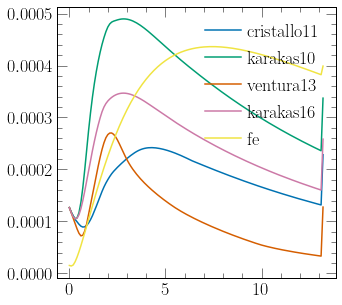

In [16]:
for model in AGB_MODELS:
    vice.yields.agb.settings["c"] = model

    out = run_model()
    x = out.history["time"][:-1]
    y = calc_agb(out.history)
    plt.plot(x, y, label=model)

out = run_model()
plt.plot(out.history["time"][:-1], calc_ia(out.history)/2, label="fe")
plt.legend()


/users/PAS2232/aeyobd/.local/lib/python3.6/site-packages/vice/core/singlezone/singlezone.py:1779: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  overwrite = overwrite)
/users/PAS2232/aeyobd/.local/lib/python3.6/site-packages/vice/core/singlezone/singlezone.py:1779: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  overwrite = overwrite)
/users/PAS2232/aeyobd/.local/lib/python3.6/site-packages/vice/core/singlezone/singlezone.py:1779: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  overwrite = overwrite)
/users/PAS2232/aeyobd/.local/lib/python3

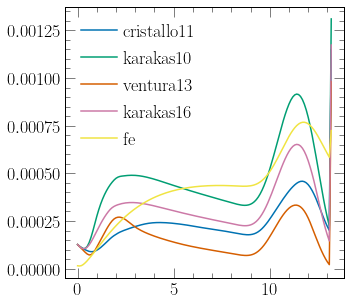

In [17]:
for model in AGB_MODELS:
    vice.yields.agb.settings["c"] = model

    out = run_model(func=lateburst)
    x = out.history["time"][:-1]
    y = calc_agb(out.history)
    plt.plot(x, y, label=model)
out = run_model(func=lateburst)
plt.plot(out.history["time"][:-1], calc_ia(out.history)/2, label="fe")
plt.legend()

/users/PAS2232/aeyobd/.local/lib/python3.6/site-packages/vice/core/singlezone/singlezone.py:1779: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  overwrite = overwrite)
/apps/project/ondemand/app_jupyter/3.0.17/lib64/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/users/PAS2232/aeyobd/.local/lib/python3.6/site-packages/vice/core/singlezone/singlezone.py:1779: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  overwrite = overwrite)
/apps/project/ondemand/app_jupyter/3.0.17/lib64/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/users/PAS2232/aeyobd/.local/lib/python3.6/s

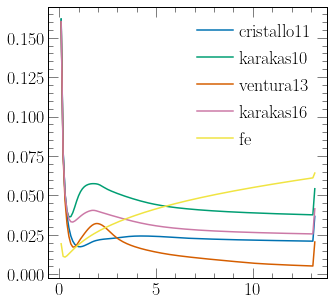

In [18]:
for model in AGB_MODELS:
    vice.yields.agb.settings["c"] = model

    out = run_model()
    x = out.history["time"][:-1]
    sfr = np.array(out.history["sfr"])[:-1]
    y_o = sfr * 0.015
    y = calc_agb(out.history)/y_o
    plt.plot(x, y, label=model)

out = run_model()
plt.plot(out.history["time"][:-1], calc_ia(out.history)/2/y_o, label="fe")
plt.legend()

/users/PAS2232/aeyobd/.local/lib/python3.6/site-packages/vice/core/singlezone/singlezone.py:1779: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  overwrite = overwrite)
/apps/project/ondemand/app_jupyter/3.0.17/lib64/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/users/PAS2232/aeyobd/.local/lib/python3.6/site-packages/vice/core/singlezone/singlezone.py:1779: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  overwrite = overwrite)
/apps/project/ondemand/app_jupyter/3.0.17/lib64/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/users/PAS2232/aeyobd/.local/lib/python3.6/s

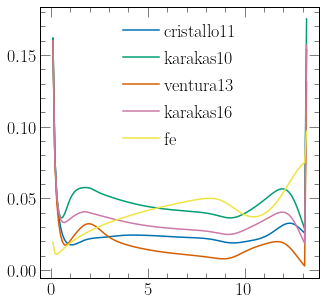

In [19]:
for model in AGB_MODELS:
    vice.yields.agb.settings["c"] = model

    out = run_model(func = lateburst)
    x = out.history["time"][:-1]
    sfr = np.array(out.history["sfr"])[:-1]
    y_o = sfr * 0.015
    y = calc_agb(out.history)/y_o
    plt.plot(x, y, label=model)

out = run_model(func = lateburst)
plt.plot(out.history["time"][:-1], calc_ia(out.history)/2/y_o, label="fe")
plt.legend()

/users/PAS2232/aeyobd/.local/lib/python3.6/site-packages/vice/core/singlezone/singlezone.py:1779: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  overwrite = overwrite)
/apps/project/ondemand/app_jupyter/3.0.17/lib64/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/apps/project/ondemand/app_jupyter/3.0.17/lib64/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


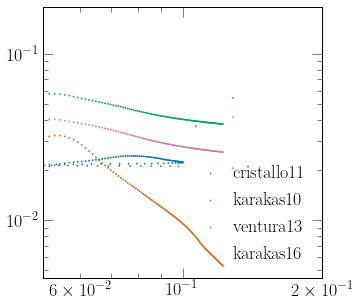

In [20]:
for model in AGB_MODELS:
    vice.yields.agb.settings["c"] = model

    out = run_model()
    x = calc_ia(out.history)/y_o
    sfr = np.array(out.history["sfr"])[:-1]
    y_o = sfr * 0.015
    y = calc_agb(out.history)/y_o
    plt.scatter(x, y, s=sfr, label=model)
plt.xlim(0.05, 0.2)

plt.legend()
plt.xscale("log")
plt.yscale("log")


/apps/project/ondemand/app_jupyter/3.0.17/lib64/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/apps/project/ondemand/app_jupyter/3.0.17/lib64/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


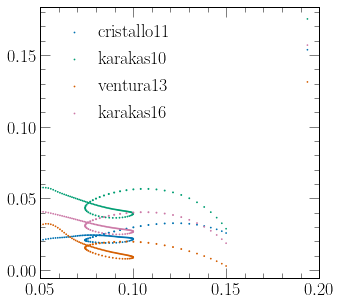

In [24]:
for model in AGB_MODELS:
    vice.yields.agb.settings["c"] = model

    out = run_model(func=lateburst)
    x = calc_ia(out.history)/y_o
    sfr = np.array(out.history["sfr"])[:-1]
    y_o = sfr * 0.015
    y = calc_agb(out.history)/y_o
    plt.scatter(x, y, s=sfr, label=model)
plt.xlim(0.05, 0.2)
plt.legend()



In [22]:
vice.solar_z("fe")/vice.solar_z("o")

0.2255244755244755

/users/PAS2232/aeyobd/.local/lib/python3.6/site-packages/vice/core/singlezone/singlezone.py:1779: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  overwrite = overwrite)
/apps/project/ondemand/app_jupyter/3.0.17/lib64/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/apps/project/ondemand/app_jupyter/3.0.17/lib64/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


(0.015, 0.03)

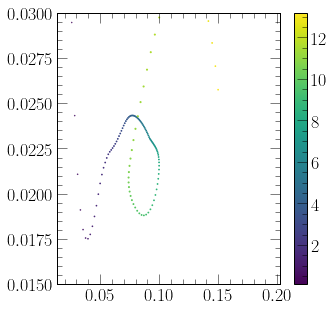

In [29]:
vice.yields.agb.settings["c"] = "cristallo11"

out = run_model(func=lateburst)
x = calc_ia(out.history)/y_o
sfr = np.array(out.history["sfr"])[:-1]
y_o = sfr * 0.015
y = calc_agb(out.history)/y_o
plt.scatter(x, y, s=sfr, label=model, c=out.history["time"][:-1])
plt.colorbar()
plt.ylim(0.015, 0.03)